In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from jax.scipy.linalg import block_diag
from jax.scipy.linalg import solve
from scipy.interpolate import RectBivariateSpline
from pde_solvers.BurgerSolver import get_burger_solver
from EquationModel import InducedRKHS

In [2]:
class KS_ETDRK2():
    def __init__(
        self,
        L,
        N,
        dt,
    ):
        self.L = L
        self.N = N
        self.dt = dt
        self.dx = L / N

        wavenumbers = jnp.fft.rfftfreq(N, d=L / (N * 2 * jnp.pi))
        self.derivative_operator = 1j * wavenumbers

        linear_operator = - self.derivative_operator**2 - self.derivative_operator**4
        self.exp_term = jnp.exp(dt * linear_operator)
        self.coef_1 = jnp.where(
            linear_operator == 0.0,
            dt,
            (self.exp_term - 1.0) / linear_operator,
        )
        self.coef_2 = jnp.where(
            linear_operator == 0.0,
            dt / 2,
            (self.exp_term - 1.0 - linear_operator * dt) / (linear_operator**2 * dt)
        )

        self.alias_mask = (wavenumbers < 2/3 * jnp.max(wavenumbers))
        
    def __call__(
        self,
        u,
    ):
        u_nonlin = - 0.5 * u**2
        u_hat = jnp.fft.rfft(u)
        u_nonlin_hat = jnp.fft.rfft(u_nonlin)
        u_nonlin_hat = self.alias_mask * u_nonlin_hat
        u_nonlin_der_hat = self.derivative_operator * u_nonlin_hat

        u_stage_1_hat = self.exp_term * u_hat + self.coef_1 * u_nonlin_der_hat
        u_stage_1 = jnp.fft.irfft(u_stage_1_hat, n=self.N)

        u_stage_1_nonlin = - 0.5 * u_stage_1**2
        u_stage_1_nonlin_hat = jnp.fft.rfft(u_stage_1_nonlin)
        u_stage_1_nonlin_hat = self.alias_mask * u_stage_1_nonlin_hat
        u_stage_1_nonlin_der_hat = self.derivative_operator * u_stage_1_nonlin_hat

        u_next_hat = u_stage_1_hat + self.coef_2 * (u_stage_1_nonlin_der_hat - u_nonlin_der_hat)
        u_next = jnp.fft.irfft(u_next_hat, n=self.N)

        return u_next

In [3]:
DOMAIN_SIZE = 100.0
N_discrete = 2000
DT = 0.01
final_time = 100


mesh = jnp.linspace(0.0, DOMAIN_SIZE, N_discrete, endpoint=False)
u_0 = (
    0.3*jnp.sin(2*jnp.pi*mesh/DOMAIN_SIZE)+
    jnp.sin(12 * jnp.pi * mesh / DOMAIN_SIZE) + 
    jnp.cos(2*jnp.pi*mesh/DOMAIN_SIZE)
)

ks_stepper_etdrk2 = KS_ETDRK2(
    L=DOMAIN_SIZE,
    N=N_discrete,
    dt=DT,
)


In [4]:
ks_stepper_etdrk2 = jax.jit(ks_stepper_etdrk2)
u_current = u_0
trj_etdrk2 = [u_current, ]
t_vals = [0]
for i in tqdm(range(int(final_time//DT)+1)):
    u_current = ks_stepper_etdrk2(u_current)
    trj_etdrk2.append(u_current)
    t_vals.append(t_vals[-1]+DT)

trj_etdrk2 = jnp.stack(trj_etdrk2)

  0%|          | 0/10000 [00:00<?, ?it/s]

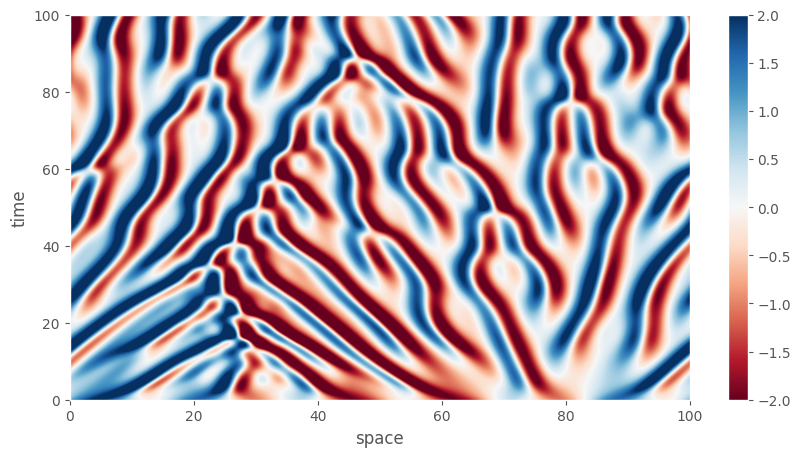

In [5]:
plt.figure(figsize=(10, 5))
plt.imshow(
    trj_etdrk2,
    cmap="RdBu",
    aspect="auto",
    origin="lower",
    extent=(0, DOMAIN_SIZE, 0, final_time),
    vmin=-2,
    vmax=2,
)
plt.colorbar()
plt.ylabel("time")
plt.xlabel("space")
plt.grid(None)
plt.show()

In [6]:
num_t_keep = 5000

tvals = jnp.array(t_vals)[:num_t_keep]
grid = jnp.hstack([mesh,mesh[-1] + (mesh[-1] - mesh[-2])])
sols = jnp.hstack([trj_etdrk2,trj_etdrk2[:,-1:]])[:num_t_keep]
t_range = jnp.array([tvals[0],tvals[-1]])
x_range = jnp.array([grid[0],grid[-1]])

interp = RectBivariateSpline(tvals,grid,sols,kx = 5,ky = 5)
ut_interp = interp.partial_derivative(1,0)

def u_true_function(x):
    return interp(x[:,0],x[:,1],grid = False)

def ut_true_function(x):
    return ut_interp(x[:,0],x[:,1],grid = False)

In [7]:
def build_tx_grid(t_range,x_range,num_grid_t,num_grid_x):
    full_t_grid = jnp.linspace(t_range[0],t_range[1],num_grid_t)
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    x_interior = full_x_grid[1:-1]
    x_boundary = full_x_grid[jnp.array([0,-1])]

    #Get interior points
    t,x = jnp.meshgrid(full_t_grid,x_interior)
    tx_interior = jnp.vstack([t.flatten(),x.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    t,x = jnp.meshgrid(full_t_grid,x_boundary)
    tx_boundary = jnp.vstack([t.flatten(),x.flatten()]).T
    return tx_interior,tx_boundary

def build_tx_grid_chebyshev(t_range,x_range,num_grid_t,num_grid_x):
    full_t_grid = jnp.linspace(t_range[0],t_range[1],num_grid_t)
    nodes = jnp.cos(jnp.pi*(2*jnp.arange(0,num_grid_x,1)[::-1])/(2*(num_grid_x-1)))
    reg_grid = jnp.linspace(-1,1,num_grid_x)
    alpha = 0.6
    nodes = alpha * nodes + (1-alpha) * reg_grid
    # nodes = jnp.sign(nodes)*jnp.abs(nodes)**(5/4)
    full_x_grid = (nodes  + (x_range[0]+1))/(2*(x_range[1]-x_range[0]))
    x_interior = full_x_grid[1:-1]
    x_boundary = full_x_grid[jnp.array([0,-1])]

    #Get interior points
    t,x = jnp.meshgrid(full_t_grid,x_interior)
    tx_interior = jnp.vstack([t.flatten(),x.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    t,x = jnp.meshgrid(full_t_grid,x_boundary)
    tx_boundary = jnp.vstack([t.flatten(),x.flatten()]).T
    return tx_interior,tx_boundary

In [8]:
num_grid_x = 40
num_grid_t = 26

tx_int,tx_bdy = build_tx_grid(t_range,x_range,num_grid_t,num_grid_x)

tx_all = jnp.vstack([tx_bdy,tx_int])

init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
num_init_obs_inds = len(init_obs_inds)


u_true = u_true_function(tx_all)

num_obs = 200
np.random.seed(40)

remaining_inds = list(
    set(list(np.arange(len(tx_int)))) - 
    set(list(np.where(tx_int[:,0]==0)[0]))
)

x_t_sample_inds = np.random.choice(remaining_inds,num_obs,replace = False)
x_t_sample_inds = jnp.hstack([init_obs_inds,x_t_sample_inds])

tx_obs = jnp.vstack([tx_bdy,tx_int[x_t_sample_inds]])

u_obs = u_true_function(tx_obs)

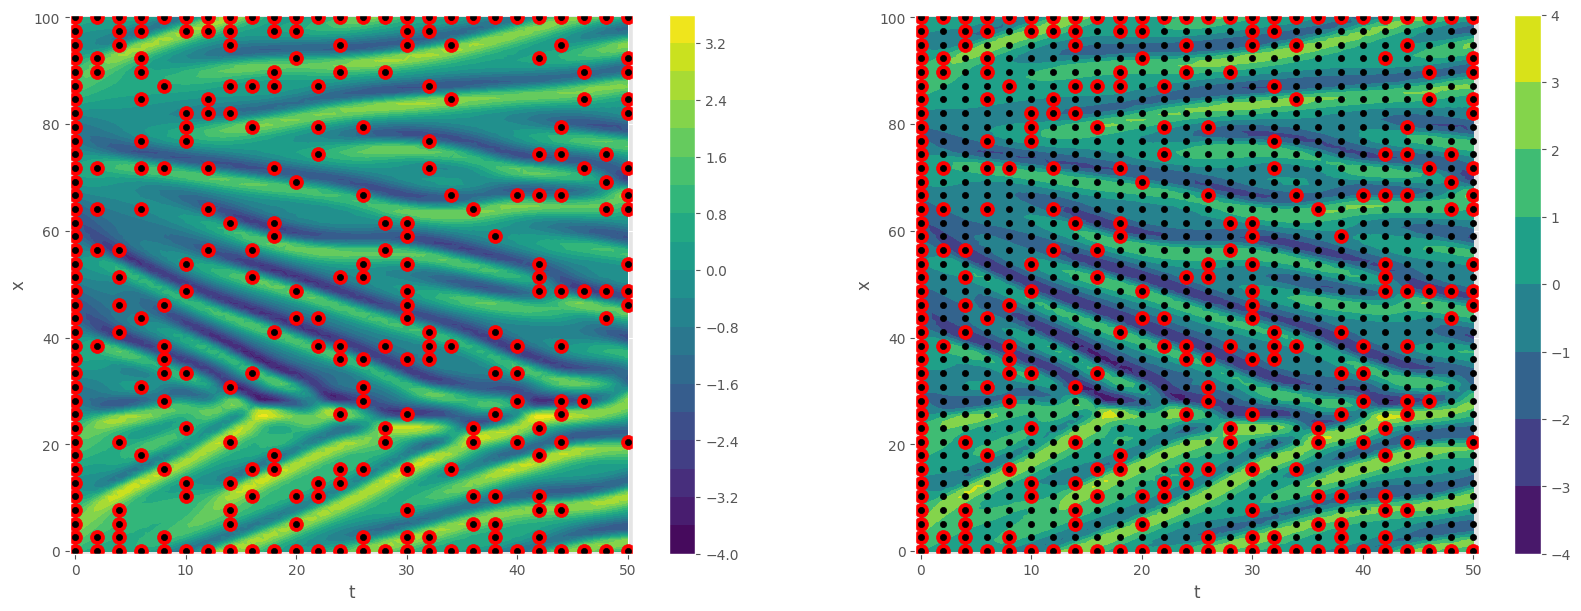

In [9]:
num_fine_grid = 100
final_time = 50
t_fine,x_fine = np.meshgrid(np.linspace(0,t_range[1],num_fine_grid),np.linspace(0,x_range[1],num_fine_grid))
tx_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),20)
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 20)

plt.xlim(t_range[0]-0.5,t_range[1]+0.5)
plt.ylim(x_range[0]-0.5,x_range[1]+0.5)
plt.xlabel("t")
plt.ylabel("x")
plt.subplot(1,2,2)
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine))
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)

plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 20)
plt.xlim(t_range[0]-0.5,t_range[1]+0.5)
plt.ylim(x_range[0]-0.5,x_range[1]+0.5)

plt.xlabel("t")
plt.ylabel("x")
plt.show()

In [36]:
from Kernels import get_gaussianRBF,get_centered_scaled_poly_kernel,get_anisotropic_gaussianRBF

def d4x_k(k,index):
    result = k
    for i in range(4):
        result = get_selected_grad(result,index,1)
    return result

feature_operators = tuple([eval_k,dx_k,dxx_k,d4x_k])


ku_mat = jnp.diag(jnp.array([0.2,1.]))
k_u = get_anisotropic_gaussianRBF(3,ku_mat)
#get_sum_of_kernels([get_gaussianRBF(0.05),get_gaussianRBF(0.2)],coefficients=[0.5,0.5])#get_gaussianRBF(0.1)

u_model = InducedRKHS(
    tx_all,
    feature_operators,
    k_u
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])
class P_model():
    kernel_function = jit(
        get_kernel_block_ops(k_P,[eval_k],[eval_k])
    )
    num_params = len(grid_features_init)

    @jit
    def predict(input_data,params):
        K = P_model.kernel_function(input_data,input_data)
        return K@params

In [46]:
from EquationModel import OperatorPDEModel

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 200
)

In [47]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize
params_init = jnp.hstack([u_params_init,jnp.zeros(P_model.num_params)])

params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-9,
    max_iter = 301,
    init_alpha=0.1,
    line_search_increase_ratio=1.4,
    print_every = 50
)

  0%|          | 0/301 [00:00<?, ?it/s]

Iteration 0, loss = 1.329, Jres = 141.1, alpha = 0.08333, improvement_ratio = 0.9997
Iteration 1, loss = 1.326, Jres = 2.001, alpha = 0.06944, improvement_ratio = 1.007
Iteration 2, loss = 1.325, Jres = 1.48, alpha = 0.05787, improvement_ratio = 1.004
Iteration 3, loss = 1.324, Jres = 1.533, alpha = 0.04823, improvement_ratio = 1.002
Iteration 4, loss = 1.323, Jres = 1.597, alpha = 0.04019, improvement_ratio = 1.002
Iteration 5, loss = 1.322, Jres = 1.663, alpha = 0.03349, improvement_ratio = 1.002
Iteration 50, loss = 0.9446, Jres = 24.71, alpha = 4.725e-05, improvement_ratio = 0.8834
Iteration 100, loss = 0.8696, Jres = 2.634, alpha = 8.402e-06, improvement_ratio = 0.8866
Iteration 150, loss = 0.8448, Jres = 24.72, alpha = 9.25e-06, improvement_ratio = 0.8602
Iteration 200, loss = 0.7658, Jres = 8.612, alpha = 8.333e-07, improvement_ratio = 0.9713
Iteration 250, loss = 0.6816, Jres = 1.611, alpha = 8.333e-07, improvement_ratio = 0.9989
Iteration 300, loss = 0.6244, Jres = 0.3751, alp

In [48]:
loss_vals = jnp.array(loss_vals)

In [49]:
importlib.reload(LM_Solve)
from LM_Solve import adaptive_refine_solution
p_adjusted,refinement_losses,reg_vals = adaptive_refine_solution(params,EqnModel,1e-8,150)

  0%|          | 0/150 [00:00<?, ?it/s]

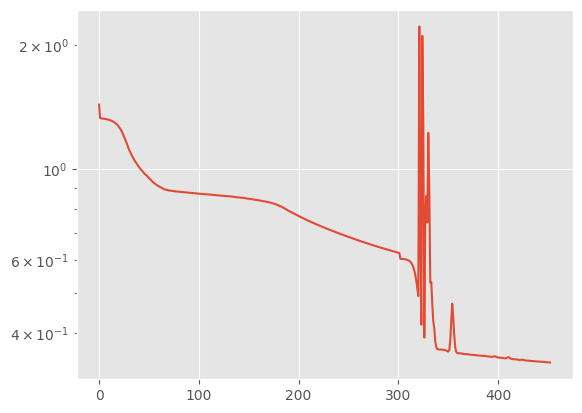

In [50]:
plt.plot(jnp.hstack([loss_vals,refinement_losses]))
plt.yscale('log')

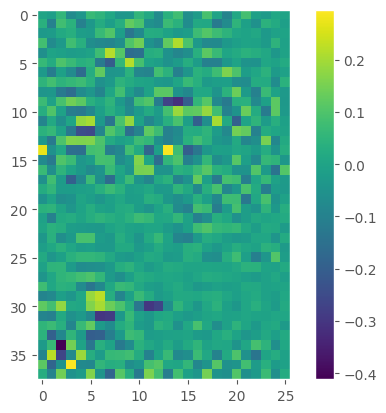

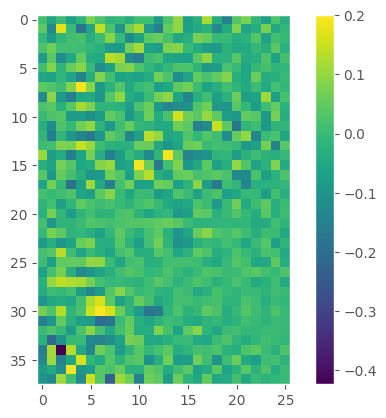

Pre Refinement  0.005735689984363163
Post Refinement  0.004216152039059278


In [51]:
equation_residuals = EqnModel.equation_residual(params)
plt.imshow(equation_residuals.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()

equation_residuals_refined = EqnModel.equation_residual(p_adjusted)
plt.imshow(equation_residuals_refined.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()
print("Pre Refinement ",jnp.mean(equation_residuals**2))
print("Post Refinement ",jnp.mean(equation_residuals_refined**2))

In [52]:
u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]

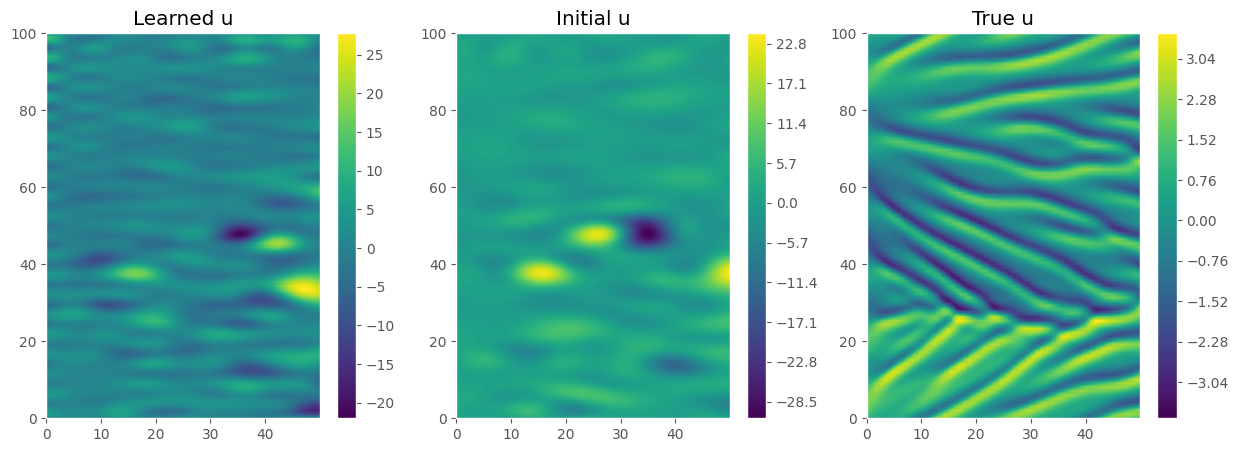

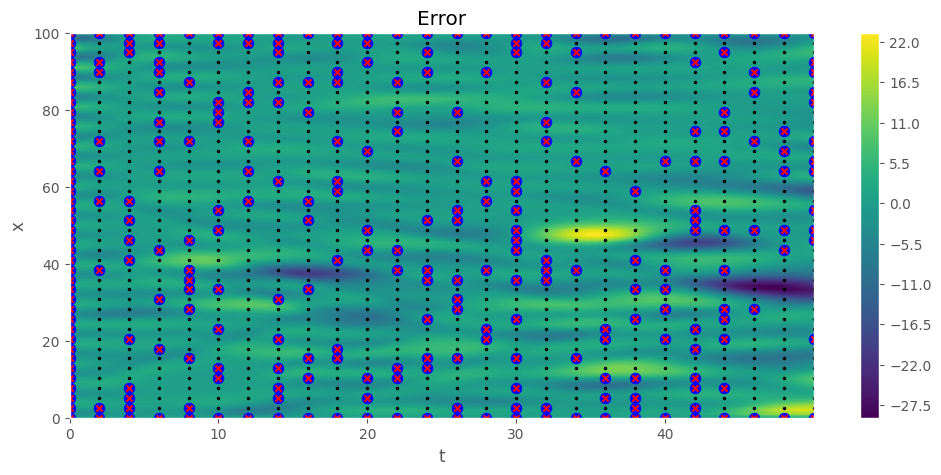

In [53]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,t_range[1],num_fine_grid),np.linspace(0,x_range[1],num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)

u_true_fine = u_true_function(tx_grid_fine)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Learned u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_eval_fine,200)
plt.colorbar()
plt.subplot(1,3,2)
plt.title("Initial u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_model.point_evaluate(tx_grid_fine,u_params_init),200)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine,200)
plt.colorbar()

plt.show()
plt.figure(figsize = (12,5))
plt.title("Error")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine-u_eval_fine,250)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='blue',s = 60)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 20,marker = 'x')


plt.xlabel("t")
plt.ylabel("x")
plt.show()

In [125]:
def compare_values(x,y):
    plt.plot([np.min(x),np.max(x)],
            [np.min(x),np.max(x)],c = 'blue',lw = 0.8)
    plt.scatter(x,y,c = 'black',s = 4)


In [152]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,t_range[1],num_fine_grid+4)[2:-2],np.linspace(0,x_range[1],num_fine_grid+4)[2:-2])
tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


# grad_u_true = jax.vmap(grad(u_single))(tx_fine_int)
# hess_u_true = jax.vmap(hessian(u_single))(tx_fine_int)

u_true_interior = u_true_function(tx_fine_int)
ut_true = interp.partial_derivative(1,0)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
ux_true = interp.partial_derivative(0,1)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
uxx_true = interp.partial_derivative(0,2)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
u4x_true = interp.partial_derivative(0,4)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)


true_features = jnp.vstack([u_true_interior,ux_true,uxx_true,u4x_true]).T
true_features = jnp.hstack([tx_fine_int,true_features])

model_grid_features = EqnModel.get_stacked_eqn_features((u_sol,))
model_features = EqnModel.get_single_eqn_features(u_model,u_sol,tx_fine_int)
#model_features = u_model.evaluate_operators(feature_operators,tx_fine_int,u_sol).reshape(len(tx_fine_int),len(feature_operators),order = 'F')

preds_ut_model_features = P_model.kernel_function(model_features,model_grid_features)@P_sol
preds_ut_true_features = P_model.kernel_function(true_features,model_grid_features)@P_sol

init_P_features = EqnModel.get_stacked_eqn_features((u_params_init,))

K = P_model.kernel_function(init_P_features,init_P_features)

P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.get_stacked_rhs_op((u_params_init,)))

init_P_features_fine = u_model.evaluate_operators(
    feature_operators,tx_fine_int,u_params_init
    ).reshape(len(tx_fine_int),len(feature_operators),order = 'F')
init_P_features_fine = jnp.hstack([tx_fine_int,init_P_features_fine])

P_preds_init_model_features_init = P_model.kernel_function(init_P_features_fine,init_P_features)@P_params_naive

P_preds_init_model_features = P_model.kernel_function(model_features,init_P_features)@P_params_naive
P_preds_init_true_features = P_model.kernel_function(true_features,init_P_features)@P_params_naive

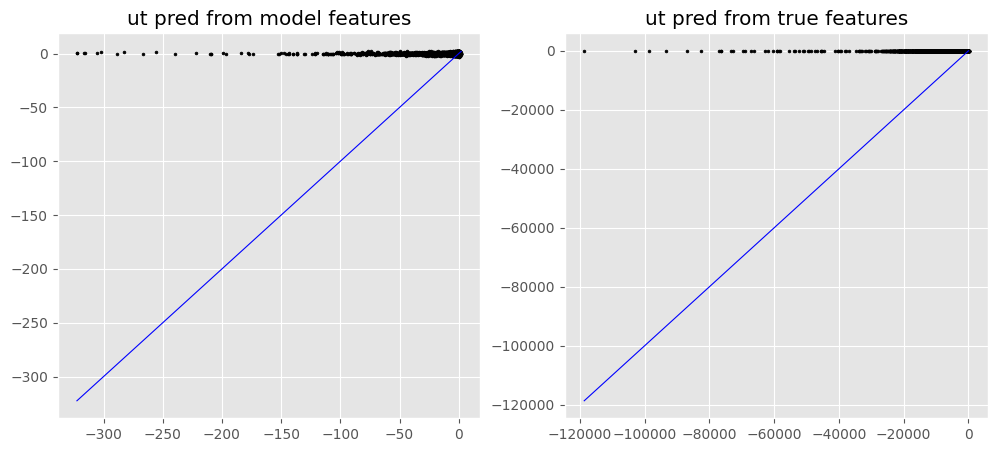

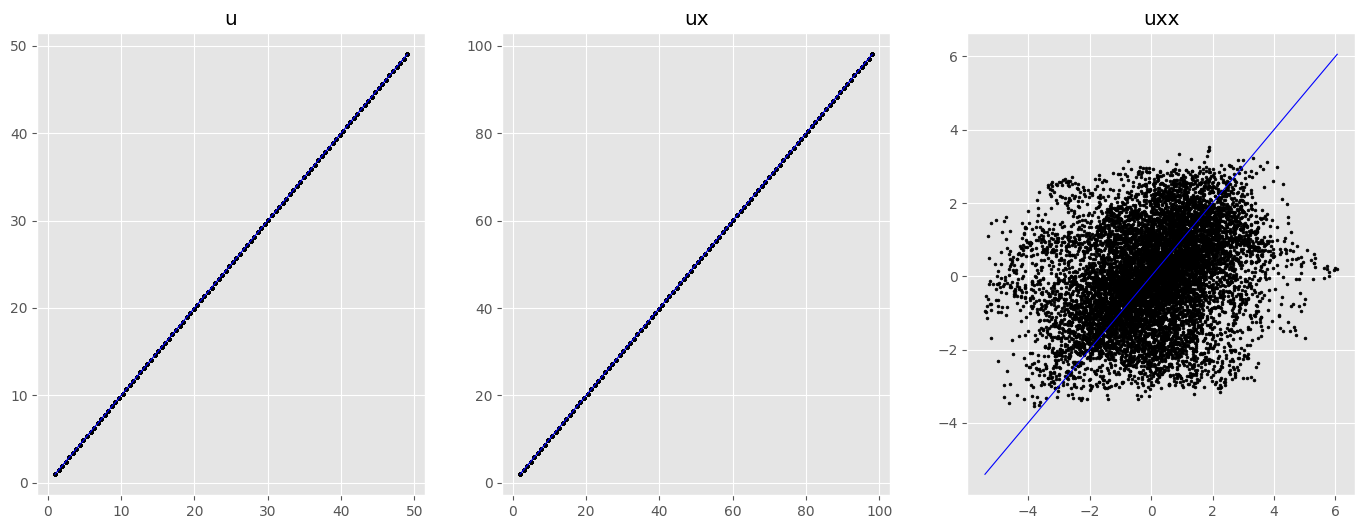

In [153]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.title('ut pred from model features')
compare_values(preds_ut_model_features,ut_true)
plt.subplot(1,2,2)
plt.title('ut pred from true features')
compare_values(preds_ut_true_features,ut_true)
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(1,3,1)
plt.title('u')
compare_values(model_features[:,0],true_features[:,0])
plt.subplot(1,3,2)
plt.title('ux')
compare_values(model_features[:,1],true_features[:,1])
plt.subplot(1,3,3)
plt.title("uxx")
compare_values(model_features[:,2],true_features[:,2])
plt.show()


In [154]:
def get_nrmse(true,pred):
    return jnp.sqrt(jnp.mean((true-pred)**2)/jnp.mean(true**2))

def get_clipped_nrmse(true,pred, perc = 1):
    pred_clipped = jnp.clip(pred,jnp.percentile(pred,perc),jnp.percentile(pred,100-perc))
    true_clipped = jnp.clip(true,jnp.percentile(true,perc),jnp.percentile(true,100-perc))
    return get_nrmse(true_clipped,pred_clipped)


def get_nmae(true,pred):
    return jnp.mean(jnp.abs(true-pred))/jnp.mean(jnp.abs(true))

print("Normalized RMSE")
print("Optimized model feature predictions ",get_nrmse(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_nrmse(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_nrmse(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features_init))

print("Clipped Normalized RMSE")
print("Optimized model feature predictions ",get_clipped_nrmse(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_clipped_nrmse(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_model_features_init))


print("Normalized MAE")
print("Optimized model feature predictions ",get_nmae(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_nmae(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_nmae(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_nmae(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_nmae(ut_true,P_preds_init_model_features_init))

Normalized RMSE
Optimized model feature predictions  35.841231437501825
Optimized true feature predictions  11320.669248087139
2 step model feature predictions  13.976261138192141
2 step true feature predictions  2444.869842876897
2 step init model feature predictions  1.0429977025702888
Clipped Normalized RMSE
Optimized model feature predictions  29.275756968087627
Optimized true feature predictions  9164.165779850651
2 step model feature predictions  12.210999551831334
2 step true feature predictions  1999.5661215415676
2 step init model feature predictions  1.036096388807232
Normalized MAE
Optimized model feature predictions  21.324636012017212
Optimized true feature predictions  6351.256515585345
2 step model feature predictions  9.456761266803156
2 step true feature predictions  1380.8551388656233
2 step init model feature predictions  1.06217003557207


In [159]:
get_nrmse(u_true_interior,u_model.point_evaluate(tx_fine_int,u_sol))

Array(1.40072117, dtype=float64)

In [160]:
get_nrmse(u_true_interior,u_model.point_evaluate(tx_fine_int,u_params_init))

Array(1.64765174, dtype=float64)